In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import re

In [2]:
saveFigures=False

In [3]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

In [4]:
elemProp = pd.read_excel('datasets/ElementalDensityIonizationTable.xlsx')
elemDensity = elemProp[['symbol', 'density [g/cm3]']]

def vegardsDensity(comp):
    '''
    input: Composition object
    '''
        
    density=0
    elemSet = set(comp.elements)
    subscriptCnt = 0
    
    for elem in elemSet:
        subscriptCnt += comp[elem]
        try: 
            densityPart = comp[elem]*elemDensity[ elemDensity['symbol'] == str(elem)]['density [g/cm3]'].item()
        except:
            print('element {} not found?'.format(elem))
            return 'error'
            
        density += densityPart
        # print('element {} added density of {}: {}'.format(elem, densityPart, density))
                
    # print(subscriptCnt)
    return density / subscriptCnt

# Build Model: Density

Import feature set, import data

In [5]:
with gzip.open('./datasets/MAPI_density_features.pkl.gz', 'rb') as fp:
    X_mp = pkl.load(fp)
with gzip.open('./datasets/MAPI_density_data.pkl.gz', 'rb') as fd:
    mpData = pkl.load(fd)
with gzip.open('./datasets/MAPI_density_featLabels.pkl.gz', 'rb') as fl:
    feat_labels = pkl.load(fl)

In [6]:
mpData.head(10)

,density,material_id,pretty_formula,comp
0,8.902616,mp-998890,Cu,(Cu)
1,8.930286,mp-989695,Cu,(Cu)
2,8.935841,mp-989782,Cu,(Cu)
3,8.886169,mp-1010136,Cu,(Cu)
4,0.174855,mp-1056079,Cu,(Cu)
5,8.517518,mp-1059259,Cu,(Cu)
6,4.577375,mp-1120774,Cu,(Cu)
7,8.888270,mp-30,Cu,(Cu)
8,6.981483,mp-79,Zn,(Zn)
9,1.765008,mp-1056702,Mg,(Mg)


In [7]:
density_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [8]:
print(np.shape(X_mp))
print(np.shape(mpData))

(3174, 152)
(3174, 4)


In [9]:
featCleanImpute(X_mp)
np.shape(X_mp)

(3174, 152)

In [10]:
%%time
density_model.fit(X_mp, y=mpData['density'])

Wall time: 1.64 s


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [11]:
print(np.shape(X_mp)) # should be (3174 x 152)
print(len(density_model.steps[1][1].feature_importances_)) # should be 152
print(len(feat_labels))
print(len(dens_featurizer.feature_labels())) # should be 152

# If you allow the pipeline imputer to operate on the array, 
# it removes an entire feature without telling you....
# Own featCleanImpute doesn't, somehow...

(3174, 152)
152
152
152


In [12]:
# Look at feature importances when trained on the whole data set
featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
# featureImp.to_csv(os.path.join(os.getcwd(),'results','defaultDensityModel_features.csv'))

In [13]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

# Generate learning curves, assess initial quality of model

In [14]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_mp, mpData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

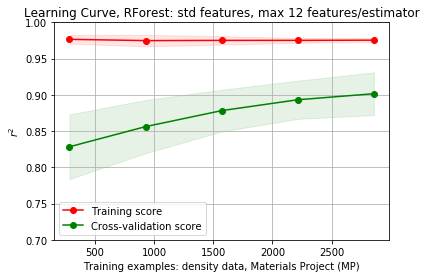

In [15]:
plt.figure()
plt.title('Learning Curve, RForest: std features, max 12 features/estimator')
plt.xlabel("Training examples: density data, Materials Project (MP)")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim([0.7, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v1.0_LearningCurve.png'))
    print('figure saved')

In [16]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
mpData['density_predict'] = np.nan
for train_index, test_index in kf.split(mpData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_mp[train_index,:], mpData['density'][train_index])
    
    y_densPredict = density_model.predict(X_mp[test_index,:])
    mpData['density_predict'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


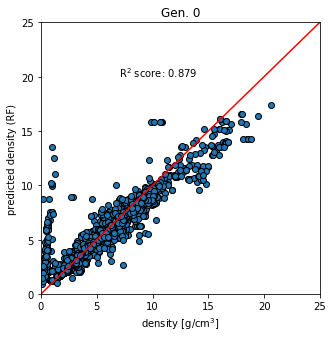

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(mpData['density'], mpData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (RF)')

r2Std = r2_score(mpData['density'], mpData['density_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2Std))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Gen. 0')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v0_Scatter.png'))
    print('figure saved')

Compare to Vegard's law, rule of mixtures

In [18]:
mpData['density_vegards'] = np.nan
mpData['density_vegards'] = [vegardsDensity(c) for c in mpData['comp']]
mpData['vegards_diff'] = mpData['density'] - mpData['density_vegards']

In [19]:
#mpData['density_vegards'] = pd.Series([vegardsDensity(comp) for comp in mpData['comp']])
r2Vegards = r2_score(mpData['density'],mpData['density_vegards'])
r2RF = r2_score(mpData['density'], mpData['density_predict'])
print('Vegards: {}, Random Forest Regressor: {}'.format(r2Vegards, r2RF))

Vegards: 0.7923073241994684, Random Forest Regressor: 0.8788363737331671


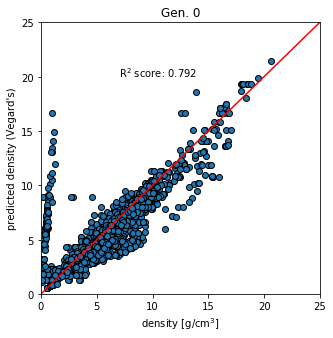

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(mpData['density'], mpData['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s)')
plt.title('Gen. 0')

r2V = r2_score(mpData['density'], mpData['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v0_Vegards_Scatter.png'))
    print('figure saved')

# MAPI data on MG model

In [21]:
with gzip.open('./datasets/MG_density_model.pkl.gz', 'rb') as fp:
    mg_density_model = pkl.load(fp)

In [22]:
mpData['MG_predict'] = mg_density_model.predict(X_mp)

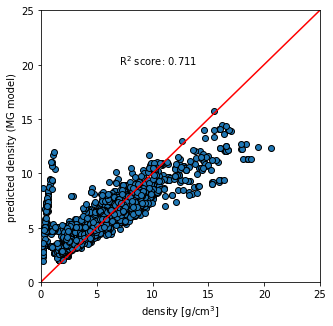

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(mpData['density'], mpData['MG_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (MG model)')

r2V = r2_score(mpData['density'], mpData['MG_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCRonMG-v0_Scatter.png'))
    print('figure saved')

# Investigating poorly performing predictions

In [24]:
largeErrorDensity = mpData[ [ (x<3) for x,y in zip(mpData['density'], mpData['density_vegards']) ]]
print(len(largeErrorDensity))
print(len(mpData))

768
3174


In [25]:
largeErrorDensity.head()

,density,material_id,pretty_formula,comp,density_predict,density_vegards,vegards_diff,MG_predict
4,0.174855,mp-1056079,Cu,(Cu),8.695421,8.96,-8.785145,8.658205
9,1.765008,mp-1056702,Mg,(Mg),1.760968,1.74,0.025008,2.969697
10,1.760290,mp-110,Mg,(Mg),1.760968,1.74,0.020290,2.969697
11,1.580195,mp-1055956,Mg,(Mg),1.760968,1.74,-0.159805,2.969697
12,1.781006,mp-1056351,Mg,(Mg),1.760968,1.74,0.041006,2.969697


In [26]:
mpData.head()

,density,material_id,pretty_formula,comp,density_predict,density_vegards,vegards_diff,MG_predict
0,8.902616,mp-998890,Cu,(Cu),8.695421,8.96,-0.057384,8.658205
1,8.930286,mp-989695,Cu,(Cu),8.695421,8.96,-0.029714,8.658205
2,8.935841,mp-989782,Cu,(Cu),8.695421,8.96,-0.024159,8.658205
3,8.886169,mp-1010136,Cu,(Cu),8.695421,8.96,-0.073831,8.658205
4,0.174855,mp-1056079,Cu,(Cu),8.695421,8.96,-8.785145,8.658205


error std: 1.4317474657696638, error mean: 0.1981922911473331


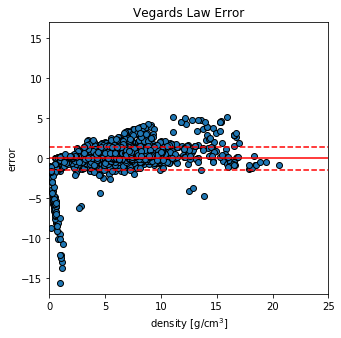

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(mpData['density'], mpData['vegards_diff'], edgecolors='k')
plt.plot([0,25], [0,0], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('error')
plt.title('Vegards Law Error')

stddev = np.std(mpData['vegards_diff'])
mean = np.mean(mpData['vegards_diff'])
plt.plot([0, 25], [stddev, stddev], 'r--')
plt.plot([0, 25], [-stddev, -stddev], 'r--')

plt.xlim([0,25])
plt.ylim([-17,17])

print('error std: {}, error mean: {}'.format(stddev, mean))

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v0_Vegards_Error.png'))
    print('figure saved')

In [28]:
len(mpData)/50

63.48

In [29]:
np.shape(mpData['vegards_diff'])

(3174,)

error std: 1.4317474657696638, error mean: 0.1981922911473331


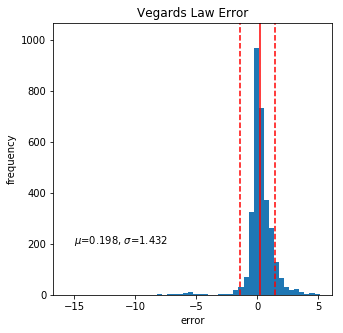

In [30]:
plt.figure(figsize=(5,5))
[n, bins, patches] = plt.hist(mpData['vegards_diff'], bins=50)

plt.xlabel('error')
plt.ylabel('frequency')
plt.title('Vegards Law Error')

plt.ylim([1,1.1*np.max(n)])

stddev = np.std(mpData['vegards_diff'])
mean = np.mean(mpData['vegards_diff'])
plt.plot([mean, mean], [0, 1.2*np.max(n)], 'r')
plt.plot([stddev, stddev], [0, 1.2*np.max(n)], 'r--')
plt.plot([-stddev, -stddev], [0, 1.2*np.max(n)], 'r--')

plt.text(-15,200, '$\mu$={:.3f}, $\sigma$={:.3f}'.format(mean, stddev))
print('error std: {}, error mean: {}'.format(stddev, mean))


if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v0_Vegards_Error_hist.png'))
    print('figure saved')

In [31]:
# Drop troublesome compositions
X_notTrouble = X_mp[ [not (x<3) for x,y in 
                              zip(mpData['density'], mpData['density_vegards']) ] ]

In [32]:
#  Examine performance without outliers (trouble compositions)
notTroubleDF = mpData[ [not(x<3) for x,y in 
                            zip(mpData['density'], mpData['density_vegards'])] ] 
notTroubleDF.reset_index(inplace=True, drop=True)

#  Examine performance without outliers in normal model
print('Density Prediction, r2 sans outliers: {}'.format(r2_score(notTroubleDF['density_predict'], notTroubleDF['density'])))

Density Prediction, r2 sans outliers: 0.8763672773018996


In [33]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
impDF = pd.DataFrame()
kf = KFold(5)
rep=0
notTroubleDF['density_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density'][train_index])
    
    y_densPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['density_predict'][test_index] = y_densPredict
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    impDF = impDF.append(featureImp)
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


In [34]:
impDF['totalImp'] = impDF.groupby(level=0)['importance'].transform('sum')
impDFtop = impDF.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
impDFtop.to_csv(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityCR-v1_featImportance.csv'))
impDFtop.head()

top features over 5 training splits


,importance,totalImp
maximum Number,0.053196,0.283761
maximum AtomicWeight,0.063494,0.280455
mean NValence,0.052834,0.267595
maximum NValence,0.060710,0.251345
mode NValence,0.051697,0.226886


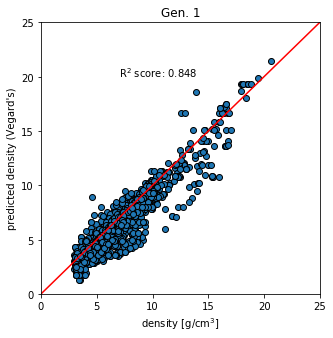

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s)')
plt.title('Gen. 1')

r2V = r2_score(notTroubleDF['density'], notTroubleDF['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v1_Vegards_Scatter.png'))
    print('figure saved')

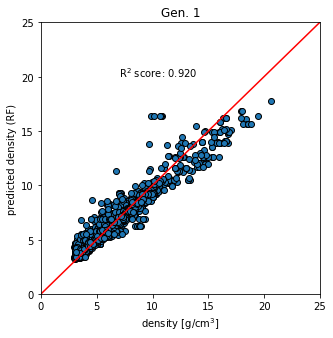

In [36]:
plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (RF)')
plt.title('Gen. 1')

r2V = r2_score(notTroubleDF['density'], notTroubleDF['density_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v1_Scatter.png'))
    print('figure saved')

# Alternate Feature Set, from rfecv and covariance matrix

[]


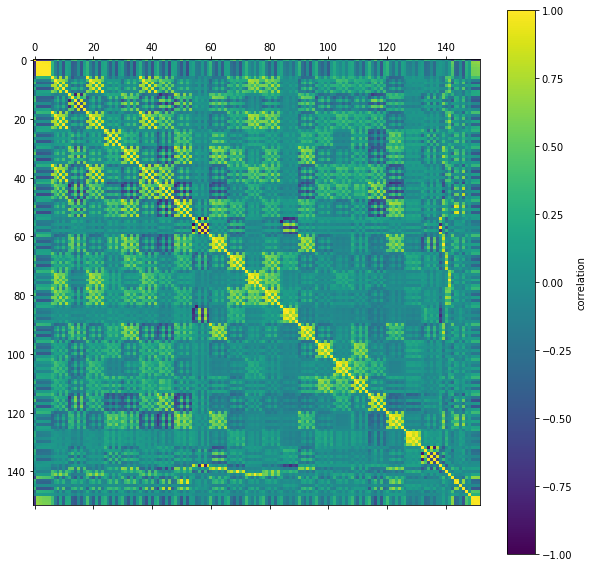

In [37]:
# Look at feature correlations..
X_mpDF = pd.DataFrame(X_mp, columns=dens_featurizer.feature_labels())
correlations = X_mpDF.corr()  # Returns NaN if values do not vary at all...

# find columns that do not vary
invariants =[ col for col in correlations.columns if correlations[col].isnull().all() ]
print(invariants)

# plot covariance matrix
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax, label='correlation')

In [38]:
# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape),k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
print('----------------------------correlated features to drop')
print(to_drop)
print('----------------------------invariants:')
print(invariants)

----------------------------correlated features to drop
['3-norm', '5-norm', '7-norm', '10-norm', 'minimum AtomicWeight', 'maximum AtomicWeight', 'range AtomicWeight', 'mean AtomicWeight', 'avg_dev AtomicWeight', 'mode AtomicWeight', 'minimum Row', 'maximum Row', 'mean Row', 'mode Row', 'avg_dev NsValence', 'avg_dev NpValence', 'avg_dev NfValence', 'range NsUnfilled', 'avg_dev NsUnfilled', 'avg_dev NpUnfilled', 'avg_dev NfUnfilled', 'avg_dev GSbandgap', 'range GSmagmom', 'avg_dev GSmagmom', 'avg_dev SpaceGroupNumber', 'avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons', 'avg f valence electrons', 'dist from 3 clusters |APE| < 0.010', 'dist from 5 clusters |APE| < 0.010']
----------------------------invariants:
[]


In [39]:
%%time
# Try recursive feature elimination
RF = RandomForestRegressor(n_estimators=100, n_jobs=1)

rfecv = RFECV(estimator=RF, step=2, cv=KFold(5),
              scoring=r2_scorer)
if True: # Takes forever
    rfecv.fit(X_mp, mpData['density']) 

KeyboardInterrupt: 

In [40]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.ylim([0.75, 1])


if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v1_rfecv.png'))
    print('figure saved')

AttributeError: 'RFECV' object has no attribute 'n_features_'

In [ ]:
# Combine data: original feature order, feature rankings by rfecv
feats = pd.DataFrame(dens_featurizer.feature_labels(), columns=['feat_name'])
feats['orig_order'] = range(len(feats))
feats['rfecv_ranking'] = rfecv.ranking_

# Mark features to drop
feats['to_remove'] = 0
feats['to_remove'] = [1 if feats['feat_name'][x] in to_drop+invariants else 0 for x in range(len(feats))]

In [ ]:
# take all features ok'd (not dropped due to covariance or invariance)
feats_subset = feats[feats['to_remove']==0]

feats_subset.sort_values(by='rfecv_ranking',inplace=True)
feats_subset.reset_index(drop=True, inplace=True)

# Create new feature matrix and list of features (differently ordered from original featurizer)
X_subset = X_notTrouble[:,feats_subset['orig_order'][:rfecv.n_features_].tolist()]
reduced_feats = feats_subset['feat_name'][:rfecv.n_features_]

In [ ]:
print('Number of samples: {}'.format(len(notTroubleDF)))
print('Shape of new feature array: {}'.format(np.shape(X_subset)))
print(np.shape(X_mp))
print('Taking {} features out of original {}'.format(len(reduced_feats), np.shape(X_mp)[1]))

### After feature reduction, try re-evaluating model performance

In [ ]:
densModel_elimFeats = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [ ]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
impDF = pd.DataFrame()

kf = KFold(5)
rep=0
notTroubleDF['density_predict_rfecv'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}'.format(rep))
    densModel_elimFeats.fit(X_subset[train_index,:], notTroubleDF['density'][train_index])
    
    y_densPredict = densModel_elimFeats.predict(X_subset[test_index,:])
    notTroubleDF['density_predict_rfecv'][test_index] = y_densPredict
    
    featureImp = pd.DataFrame(densModel_elimFeats.steps[1][1].feature_importances_,
                          index=reduced_feats,
                          columns=['importance']).sort_values('importance',ascending=False)
    impDF = impDF.append(featureImp)
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

In [ ]:
impDF['totalImp'] = impDF.groupby(level=0)['importance'].transform('sum')
impDFtop = impDF.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
impDFtop.to_csv(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityCR-v2_featImportance_190319_1.csv'))
impDFtop.head()

figure saved


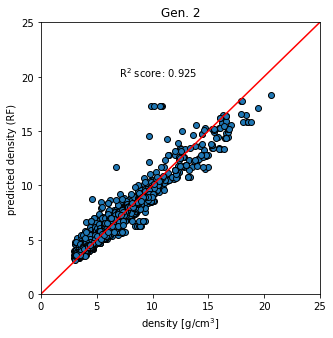

In [136]:
# plot Comparison, report r2
r2rfecv = r2_score(notTroubleDF['density'], notTroubleDF['density_predict_rfecv'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_predict_rfecv'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (RF)')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2rfecv))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Gen. 2')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityCR-v2_Scatter.png'))
    print('figure saved')

figure saved


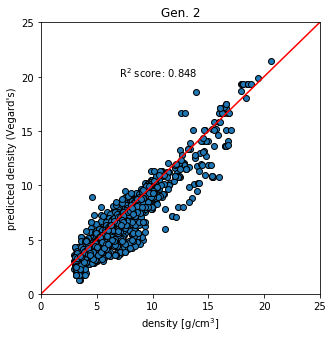

In [143]:
plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s)')
plt.title('Gen. 2')

r2V = r2_score(notTroubleDF['density'], notTroubleDF['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityCR-v2_Vegards_Scatter.png'))
    print('figure saved')

# Train model on difference from Vegards Predictions

In [69]:
print('mean difference: {:.3f}, variance {:.3f}'.format(mpData['vegards_diff'].mean(), mpData['vegards_diff'].var()))
print('max difference: {:.3f}, min difference {:.3f}'.format(mpData['vegards_diff'].max(), mpData['vegards_diff'].min()))

mean difference: 0.198, variance 2.051
max difference: 5.125, min difference -15.680


In [70]:
densDiffModel = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [71]:
%%time
densDiffModel.fit(X_mp, mpData['vegards_diff'])

Wall time: 1.95 s


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

## Train on difference between density and vegards, see what features float up
Not including outliers

In [37]:
notTroubleDF.head()

,density,material_id,pretty_formula,comp,density_predict,density_vegards,vegards_diff
0,8.902616,mp-998890,Cu,(Cu),8.577152,8.96,-0.057384
1,8.930286,mp-989695,Cu,(Cu),8.577152,8.96,-0.029714
2,8.935841,mp-989782,Cu,(Cu),8.577152,8.96,-0.024159
3,8.886169,mp-1010136,Cu,(Cu),8.577152,8.96,-0.073831
4,8.517518,mp-1059259,Cu,(Cu),8.577152,8.96,-0.442482


In [39]:
%%time
# Try recursive feature elimination
RF = RandomForestRegressor(n_estimators=100, n_jobs=1)

rfecv_diff = RFECV(estimator=RF, step=2, cv=KFold(5),
              scoring=r2_scorer)
if True: # Takes forever
    rfecv_diff.fit(X_mp, mpData['vegards_diff']) 

Wall time: 41min 50s


Optimal number of features : 130
figure saved


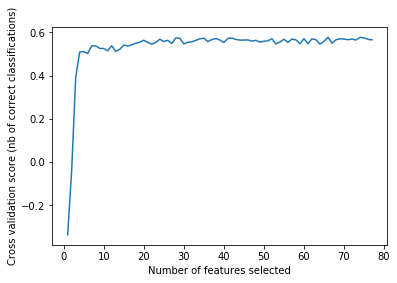

In [40]:
print("Optimal number of features : %d" % rfecv_diff.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_diff.grid_scores_) + 1), rfecv_diff.grid_scores_)
#plt.ylim([0.75, 0.85])

if True:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityCR-v3_rfecv.png'))
    print('figure saved')

In [45]:
# Combine data: original feature order, feature rankings by rfecv
feats_diff = pd.DataFrame(dens_featurizer.feature_labels(), columns=['feat_name'])
feats_diff['orig_order'] = range(len(feats_diff))
feats_diff['rfecv_ranking'] = rfecv_diff.ranking_

# Mark features to drop
feats_diff['to_remove'] = 0
feats_diff['to_remove'] = [1 if feats_diff['feat_name'][x] in to_drop+invariants else 0 for x in range(len(feats_diff))]

# take all features ok'd (not dropped due to covariance or invariance
feats_diff_subset = feats_diff[feats_diff['to_remove']==0]

feats_diff_subset.sort_values(by='rfecv_ranking',inplace=True)
feats_diff_subset.reset_index(drop=True, inplace=True)

# Create new feature matrix and list of features (differently ordered from original featurizer)
X_diff_subset = X_notTrouble[:,feats_diff_subset['orig_order'][:rfecv_diff.n_features_].tolist()]
reduced_feats_diff = feats_diff_subset['feat_name'][:rfecv_diff.n_features_]

In [46]:
# Train on difference
diffFeatTop5 = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['diff_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_diff_subset[train_index,:], notTroubleDF['vegards_diff'][train_index])
    
    y_diffPredict = density_model.predict(X_diff_subset[test_index,:])
    notTroubleDF['diff_predict'][test_index] = y_diffPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=reduced_feats_diff,
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    diffFeatTop5 = diffFeatTop5.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 1924
                        importance
feat_name                         
mean GSbandgap            0.062309
maximum GSbandgap         0.047563
minimum CovalentRadius    0.046825
avg_dev Row               0.045927
mode CovalentRadius       0.038509
Split #1, training on 1925
                        importance
feat_name                         
minimum Number            0.047714
range Row                 0.046602
mean GSbandgap            0.043291
minimum CovalentRadius    0.042792
avg_dev Row               0.040015
Split #2, training on 1925
                        importance
feat_name                         
mean GSbandgap            0.052701
minimum CovalentRadius    0.050274
avg_dev Row               0.049164
minimum Number            0.049106
range Row                 0.041082
Split #3, training on 1925
                importance
feat_name                 
Yang delta        0.052263
mode Number       0.050610
minimum Number    0.044387
mean GSbandgap    0.04

In [47]:
diffFeatTop5['totalImp'] = diffFeatTop5.groupby(level=0)['importance'].transform('sum')
diffFeatTop = diffFeatTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
diffFeatTop.to_csv(os.path.join(os.getcwd(),'results', 'finalFigs',
                                'densityCR-v3_featImportance.csv'))
diffFeatTop.head()

top features over 5 training splits


,importance,totalImp
feat_name,,
mean GSbandgap,0.062309,0.269277
minimum Number,0.034890,0.225965
minimum CovalentRadius,0.046825,0.213724
avg_dev Row,0.045927,0.208296
maximum GSbandgap,0.047563,0.179203


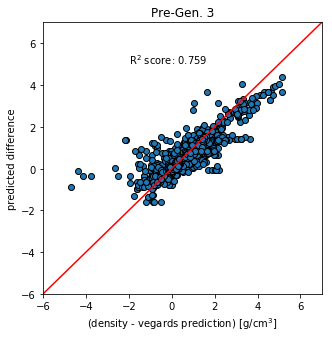

In [48]:
# plot Comparison, report r2
r2noOutDiff = r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'], edgecolors='k')
plt.plot([-6,7], [-6,7], 'r-')
plt.xlabel('(density - vegards prediction) [g/cm$^3$]')
plt.ylabel('predicted difference')


plt.text(-2,5, 'R$^2$ score: {:.3f}'.format(r2noOutDiff))
plt.xlim([-6,7])
plt.ylim([-6,7])
plt.title('Pre-Gen. 3')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityCR-v3_differenceScatter.png'))
    print('figure saved')

In [50]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_diff_subset, notTroubleDF['vegards_diff'], 
                                                                    cv=ShuffleSplit(), scoring=r2_scorer)

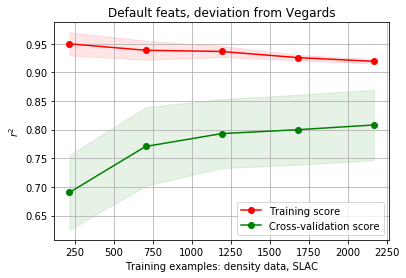

In [51]:
plt.figure()
plt.title('Default feats, deviation from Vegards')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc=4)
#plt.ylim([0.4, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs',
                             'densityMG-v2.0_LearningCurve.png'))
    print('saved figure')

In [52]:
# Look at mean absolute err with this new data set:

mae = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_predict'])
mae_vegards = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_vegards'])
print('MAE for random forest: {:.4f} vs vegards law {:.4f}'.format(mae, mae_vegards))
mae_diff = mean_absolute_error(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])
print(mae_diff)

MAE for random forest: 0.4919 vs vegards law 0.7176
0.272394857443256


# Assess performance of using difference predictions instead of full model 

0.9713214097524305


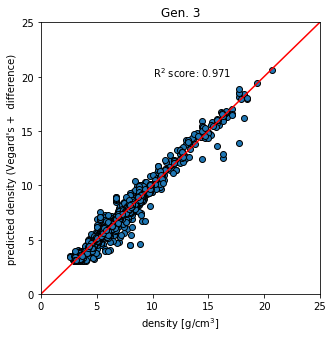

In [53]:
notTroubleDF['vPlusDiff'] = notTroubleDF['density_vegards'] + notTroubleDF['diff_predict']
r2Comp = r2_score(notTroubleDF['density'], notTroubleDF['vPlusDiff'])
print(r2Comp)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vPlusDiff'], notTroubleDF['density'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s +  difference)')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Comp))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Gen. 3')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityCR-v3_Scatter.png'))
    print('figure saved')

# Try to predict Vegard's law directly

In [80]:
# Train on difference
vegardFeats = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['vegards_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_subset[train_index,:], notTroubleDF['density_vegards'][train_index])
    
    y_pred = density_model.predict(X_subset[test_index,:])
    notTroubleDF['vegards_predict'][test_index] = y_pred
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=reduced_feats,
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    vegardFeats = vegardFeats.append(featureImp)

    rep+=1

Split #0, training on 1924
Split #1, training on 1925
Split #2, training on 1925
Split #3, training on 1925
Split #4, training on 1925


In [82]:
# Sort and compile importances
vegardFeats['totalImp'] = vegardFeats.groupby(level=0)['importance'].transform('sum')
vegardFeats = vegardFeats.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
vegardFeats.to_csv(os.path.join(os.getcwd(),'results','densityCR-Vegards_featureImportance.csv'))
vegardFeats.head()

top features over 5 training splits


,importance,totalImp
feat_name,,
mean NValence,0.239914,0.239914
mode Number,0.145146,0.145146
mode NValence,0.140335,0.140335
maximum Number,0.099731,0.099731
maximum NValence,0.075129,0.075129


0.9442751589981614


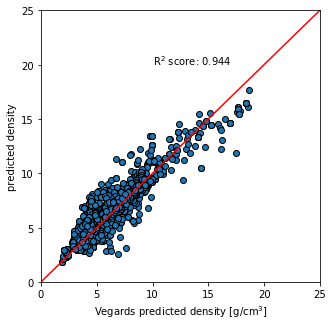

In [83]:
r2Veg = r2_score(notTroubleDF['density_vegards'], notTroubleDF['vegards_predict'])
print(r2Veg)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_predict'], notTroubleDF['density_predict'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('Vegards predicted density [g/cm$^3$]')
plt.ylabel('predicted density')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Veg))
plt.xlim([0,25])
plt.ylim([0,25])
#plt.title('')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-Vegards_predictScatter.png'))
    print('figure saved')

In [ ]:
# Once satisfied with feature set, overwrite original datasets?

with gzip.open('./datasets/MAPIdensity_features_subset.pkl.gz', 'wb') as fp:
    pkl.dump(X_subset, fp)
with gzip.open('./datasets/MAPIdensity_data_subset.pkl.gz', 'wb') as fd:
    pkl.dump(notTroubleDF, fd)
with gzip.open('./datasets/MAPIreduced_feats.pkl.gz', 'wb') as fr:
    pkl.dump(reduced_feats, fr)